<a href="https://colab.research.google.com/github/sreent/deep-learning/blob/main/credit_risk_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

import itertools
import copy

import matplotlib.pyplot as plt

SEED = 204

## Problem Definition and Assembling Dataset

In [2]:
FILE_PATH = 'http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

HEADERS = ['Status of existing checking account', 'Duration in month', 'Credit history',
           'Purpose','Credit amount', 'Savings account/bonds', 'Present employment since',
           'Installment rate in percentage of disposable income', 'Personal status and sex',
           'Other debtors / guarantors', 'Present residence since', 'Property', 'Age in years',
           'Other installment plans', 'Housing', 'Number of existing credits at this bank',
           'Job', 'Number of people being liable to provide maintenance for', 'Telephone', 'Foreign worker', 
           'Cost Matrix(Risk)']

TARGET_VARIABLE = 'Cost Matrix(Risk)'

In [3]:
NUMERICAL_VARIABLES = ['Duration in month', 'Credit amount', 'Installment rate in percentage of disposable income',
                     'Present residence since', 'Age in years', 'Number of existing credits at this bank', 
                     'Number of people being liable to provide maintenance for']
                     
CATEGORICAL_VARIABLES = {
    'Status of existing checking account': {
        'A14': 'no checking account', 'A11': '<0 DM', 'A12': '0 <= <200 DM', 
        'A13': '>= 200 DM'
    },
    
    'Credit history': {
        'A34': 'critical account', 'A33': 'delay in paying off',
        'A32': 'existing credits paid back duly till now',
        'A31': 'all credits at this bank paid back duly',
        'A30': 'no credits taken'
    },
                 
    'Purpose': {
        'A40': 'car (new)', 'A41': 'car (used)', 'A42': 'furniture/equipment', 
        'A43': 'radio/television', 'A44': 'domestic appliances', 'A45': 'repairs', 
        'A46': 'education', 'A47' : 'vacation', 'A48': 'retraining', 'A49': 'business',
        'A410': 'others'
    },

    'Savings account/bonds': {
        'A65': 'no savings account', 'A61': '<100 DM',
        'A62': '100 <= <500 DM', 'A63': '500 <= < 1000 DM', 'A64': '>= 1000 DM'
    },

    'Present employment since': {
        'A75': '>=7 years', 'A74': '4<= <7 years',  'A73': '1<= < 4 years', 
        'A72': '<1 years', 'A71': 'unemployed'
    },

    'Personal status and sex': {
        'A95': 'female:single', 'A94': 'male:married/widowed', 'A93': 'male:single', 
        'A92': 'female:divorced/separated/married', 'A91': 'male:divorced/separated'
    },

    'Other debtors / guarantors': {
        'A101': 'none', 'A102': 'co-applicant', 'A103': 'guarantor'
    },

    'Property': {
        'A121': 'real estate', 'A122': 'savings agreement/life insurance', 
        'A123': 'car or other', 'A124': 'unknown / no property'
    },

    'Other installment plans': {
        'A143': 'none', 'A142': 'store', 'A141': 'bank'
    },
    
    'Housing': {
        'A153': 'for free', 'A152': 'own', 'A151': 'rent'
    },

    'Job': {
        'A174': 'management/ highly qualified employee', 
        'A173': 'skilled employee / official', 'A172': 'unskilled - resident', 
        'A171': 'unemployed/ unskilled  - non-resident'
    },
    
    'Telephone': {
        'A192': 'yes', 'A191': 'none'
    },

    'Foreign worker': {
        'A201': 'yes', 'A202': 'no'
    }
}

In [4]:
# Load loan data from URL using pandas read_csv method
df = pd.read_csv(FILE_PATH, sep=" ", header=None)

# The data file is headless, i.e. without column names. Hence, we've to assign the column names to our data frame. 
df.columns = HEADERS

# Preview data to check if the column names are assigned properly and also the columns' variable types
df.head()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker,Cost Matrix(Risk)
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [5]:
# Target columns
target = df[TARGET_VARIABLE]

# Reformat entries to be either 0 (not default) and 1 (default), instead of 1 and 2. 
# This format is preferred in case of binary classificaiton problem.
target = target - 1

# Preview if 
print("The target column is now re-valued from [1, 2] to", target.unique(), ".")

The target column is now re-valued from [1, 2] to [0 1] .


In [6]:
# Feature columns to be used as predictors
features = df.drop(columns=[TARGET_VARIABLE])

# Replace encoded entries, e.g. Axxx, with their orignal values
for column, attributes in CATEGORICAL_VARIABLES.items() :
  features[column] = features[column].map(attributes) 

features.head()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,Present residence since,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker
0,<0 DM,6,critical account,radio/television,1169,no savings account,>=7 years,4,male:single,none,4,real estate,67,none,own,2,skilled employee / official,1,yes,yes
1,0 <= <200 DM,48,existing credits paid back duly till now,radio/television,5951,<100 DM,1<= < 4 years,2,female:divorced/separated/married,none,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,no checking account,12,critical account,education,2096,<100 DM,4<= <7 years,2,male:single,none,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,<0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,<100 DM,4<= <7 years,2,male:single,guarantor,4,savings agreement/life insurance,45,none,for free,1,skilled employee / official,2,none,yes
4,<0 DM,24,delay in paying off,car (new),4870,<100 DM,1<= < 4 years,3,male:single,none,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


## Evaluation Protocol

## Data Preparation

In [7]:
DATA_POINTS = len(target)
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, random_state=42, shuffle=True, stratify=target.values)

In [8]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), list(CATEGORICAL_VARIABLES.keys())),
    ('standard_scaler', StandardScaler(), NUMERICAL_VARIABLES)])

_ = preprocessor.fit(X_train)

In [9]:
X_train, X_test = preprocessor.transform(X_train), preprocessor.transform(X_test)

y_train, y_test = y_train.values, y_test.values

In [10]:
CLASS_WEIGHT = {0: sum(y_train)/len(y_train), 1: 1.0-sum(y_train)/len(y_train)}

print('Class Weight:', CLASS_WEIGHT)

Class Weight: {0: 0.3, 1: 0.7}


## Developing Model that does better than a baseline

In [11]:
print('Imbalanced Class with', {0: 1.0-sum(y_train)/len(y_train), 1: sum(y_train)/len(y_train)})

Imbalanced Class with {0: 0.7, 1: 0.3}


In [12]:
print('Naive Baseline Accuracy:', 1.0-sum(y_train)/len(y_train))

Naive Baseline Accuracy: 0.7


In [13]:
# MLP Model Instatiation
def multilayer_perceptron(hidden_layers, neurons, activation, dropout, inputs, outputs,
                          optimizer, loss, metric) :
  model = Sequential()
  for layer in range(hidden_layers) :
    model.add(Dense(neurons, 
                    activation=activation, 
                    input_shape='default' if layer>1 else (inputs,)))
    model.add(Dropout(dropout))

  model.add(Dense(outputs, 
                  activation='sigmoid' if outputs==1 else 'softmax',
                  input_shape='default' if hidden_layers>0 else (inputs,)))
  
  model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

  return model

In [14]:
# Fitting MLP Classification Model
def fit_mlp_classifier(model, X, y, class_weight={}, batch_size=32, epochs=100, 
                       val_data=None, val_size=0.2, callbacks=[], seed=0) :
  if val_data is None :
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, 
                                                      random_state=seed, shuffle=True, 
                                                      stratify=y)
  else :
    X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

  history = model.fit(X_train, y_train, class_weight=class_weight, 
                      batch_size=batch_size, epochs=epochs, 
                      validation_data=(X_val, y_val),
                      callbacks=callbacks,
                      verbose=0)

  return model, model.evaluate(X_val, y_val, verbose=0)[1], history



In [15]:
OPTIMIZER = 'rmsprop'
LOSS = 'binary_crossentropy'
METRIC = tf.keras.metrics.AUC(name='AUC')

INPUTS = X_train.shape[1]
OUTPUTS = 1

model = multilayer_perceptron(hidden_layers=0, neurons=None, activation=None, dropout=None, 
                              inputs=INPUTS, outputs=OUTPUTS,
                              optimizer=OPTIMIZER, loss=LOSS, metric=METRIC)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 62        
                                                                 
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Fitting MLP Classification Model
def fit_mlp_classifier(model, X, y, class_weight={}, batch_size=32, epochs=100, 
                       val_data=None, val_size=0.2, callbacks=[], seed=0) :
  if val_data is None :
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, 
                                                      random_state=seed, shuffle=True, 
                                                      stratify=y)
  else :
    X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

  history = model.fit(X_train, y_train, class_weight=class_weight, 
                      batch_size=batch_size, epochs=epochs, 
                      validation_data=(X_val, y_val),
                      callbacks=callbacks,
                      verbose=0)

  return model, model.evaluate(X_val, y_val, verbose=0)[1], history

In [17]:
SEED = 204

# 10% of # number of (all) data points 
VALIDATION_SIZE = int(TEST_SIZE*DATA_POINTS)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE, 
                                                  random_state=SEED, shuffle=True, 
                                                  stratify=y_train)

In [18]:
batch_size = 16
EPOCHS = 100


MONITOR = 'val_loss'
PATIENCE = 10

early_stop = EarlyStopping(monitor=MONITOR, restore_best_weights=True, 
                           patience=PATIENCE, verbose=0)


model, score, history = fit_mlp_classifier(model, X_train, y_train, 
                                           class_weight=CLASS_WEIGHT, 
                                           batch_size=batch_size, epochs=EPOCHS, 
                                           val_data=(X_val, y_val), callbacks=[early_stop], seed=0)

print('AUC on Validation Dataset:', score)
print('Accuracy Score on Validation Dataset:', accuracy_score(y_val, (model.predict(X_val, verbose=0) > 0.5).astype('int32')))

AUC on Validation Dataset: 0.8154762387275696
Accuracy Score on Validation Dataset: 0.73


In [19]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

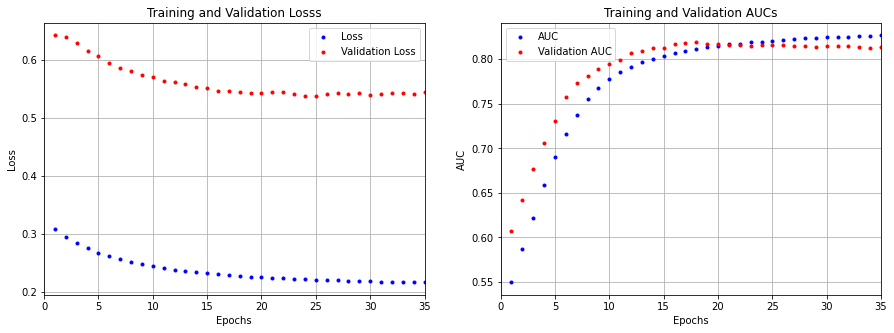

In [20]:
plot_training_history(history, monitors=['loss', 'AUC'])

## Scaling Up: an Overfitted Model

In [21]:
model = multilayer_perceptron(hidden_layers=1, neurons=42, activation='relu', dropout=0.5, 
                              inputs=61, outputs=1,
                              optimizer=OPTIMIZER, loss=LOSS, metric=METRIC)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 42)                2604      
                                                                 
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 43        
                                                                 
Total params: 2,647
Trainable params: 2,647
Non-trainable params: 0
_________________________________________________________________


In [22]:
model, score, history = fit_mlp_classifier(model, X_train, y_train, 
                                           class_weight=CLASS_WEIGHT, 
                                           batch_size=batch_size, epochs=EPOCHS, 
                                           val_data=(X_val, y_val), callbacks=[], seed=0)

print('AUC on Validation Dataset:', score)
print('Accuracy Score on Validation Dataset:', accuracy_score(y_val, (model.predict(X_val, verbose=0) > 0.5).astype('int32')))

AUC on Validation Dataset: 0.7909523844718933
Accuracy Score on Validation Dataset: 0.74


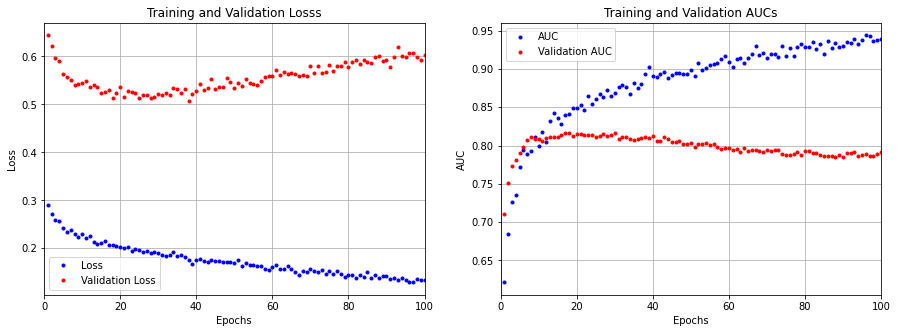

In [23]:
plot_training_history(history, monitors=['loss', 'AUC'])

## Regularisation and Hyper-Parameter Tuning

In [24]:
# Grid Search CV
def grid_search_cv(X, y, class_weight, search_space, cv, 
                   optimizer, loss, metric, 
                   epochs, callbacks=[], seed=0) :

  keys, values = zip(*search_space.items())

  stats = {}
  for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)

    scores = []
    for train, validate in kfold.split(X, y) :
      model = multilayer_perceptron(hidden_layers=params['hidden_layers'], 
                                    neurons=params['neurons'], 
                                    activation=params['activation'], 
                                    dropout=params['dropout'], 
                                    inputs=X.shape[1], outputs=1 if len(y.shape)<2 else y.shape[1],
                                    optimizer=optimizer, loss=loss, metric=metric)
      
      model, score, history = fit_mlp_classifier(model, 
                                                 X[train,:], y[train], 
                                                 class_weight=class_weight, 
                                                 batch_size=params['batch_size'], epochs=epochs, 
                                                 val_data=(X[validate,:], y[validate]), 
                                                 callbacks=callbacks, seed=seed) 
      
      scores.append( model.evaluate(X[validate,:], y[validate], verbose=0)[1] )

    stats[str(params)] = np.mean(scores)

  best_param = max(stats, key=stats.get)

  return eval(best_param), stats[best_param], stats

In [ ]:
params = {
    'hidden_layers': [1, 2, 3],
    'neurons': [32, 42, 64],
    'activation': ['relu', 'sigmoid'],
    'dropout': [0.2, 0.3, 0.4, 0.5],
    'batch_size': [16, 32, 64]
}

kfolds = 5
best_param, best_score, stats = grid_search_cv(X_train, y_train, 
                                               class_weight=CLASS_WEIGHT, 
                                               search_space=params, cv=kfolds, 
                                               optimizer=OPTIMIZER, loss=LOSS, metric=METRIC, 
                                               epochs=EPOCHS, callbacks=[early_stop], seed=0)

print('Best Hyper-Parameters:', best_param)
print('Best Cross-Validation Score:', best_score)

In [ ]:
model = multilayer_perceptron(hidden_layers=best_param['hidden_layers'], 
                              neurons=best_param['neurons'], 
                              activation=best_param['activation'], 
                              dropout=best_param['dropout'], 
                              inputs=INPUTS, outputs=OUTPUTS,
                              optimizer=OPTIMIZER, loss=LOSS, metric=METRIC)

model.summary()

In [ ]:
model, score, history = fit_mlp_classifier(model, X_train, y_train, 
                                           class_weight=CLASS_WEIGHT, 
                                           batch_size=batch_size, epochs=EPOCHS, 
                                           val_data=(X_val, y_val), callbacks=[early_stop], seed=SEED)

print('AUC on Validation Dataset:', score)
print('Accuracy Score on Validation Dataset:', accuracy_score(y_val, (model.predict(X_val, verbose=0) > 0.5).astype('int32')))

In [ ]:
plot_training_history(history, monitors=['loss', 'AUC'])

In [ ]:
print('AUC on Test Dataset:', roc_auc_score(y_test, model.predict(X_test, verbose=0)))
print('Accuracy Score on Test Dataset:', accuracy_score(y_test, (model.predict(X_test, verbose=0) > 0.5).astype('int32')))

In [ ]:
x=5

In [38]:
x=6

In [39]:
x=7

In [40]:
x=8

In [41]:
x=9